In [1]:
import os
import shutil
import cv2
import numpy as np
import pathlib
import joblib
from matplotlib import pyplot as plt
from sklearn.utils import shuffle

### Threshold the data set, images that are >= 20

In [ ]:
# Path to the original dataset folder
original_dataset_path = 'lfw_funneled'

# Path to the new threshold dataset folder
threshold_dataset_path = 'threshold_dataset'

# Create the new folder if it doesn't exist
if not os.path.exists(threshold_dataset_path):
    os.makedirs(threshold_dataset_path)

# Set the threshold for the minimum number of images
threshold = 20

# Loop through each subfolder (individual's folder) in the original dataset
for individual_folder in os.listdir(original_dataset_path):
    individual_folder_path = os.path.join(original_dataset_path, individual_folder)

    # Check if it's a directory
    if os.path.isdir(individual_folder_path):

        # Count the number of images in the individual's folder
        num_images = len(os.listdir(individual_folder_path))

        # Check if the number of images meets the threshold
        if num_images >= threshold:

            # Create a new folder in the threshold dataset path
            new_folder_path = os.path.join(threshold_dataset_path, individual_folder)

            # Check if the destination folder already exists
            if not os.path.exists(new_folder_path):

                # Copy all the images from the original folder to the new folder
                shutil.copytree(individual_folder_path, new_folder_path)

                print(f"{individual_folder} added to the threshold dataset.")
            else:
                print(f"{individual_folder} already exists in the threshold dataset.")

### Function for Pre-processing images

Define a variable call face_classifier to contain the file for facial detection

In [2]:
# Define the face classifier
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [3]:
def preprocess_and_crop_image(face_classifier: cv2.CascadeClassifier, image, target_size=(64, 64), x=100, y=100, crop_width=800, crop_height=800):
    # Load the image using OpenCV
    img = cv2.imread(image)

    # Convert the image to grayscale if it's in color
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the grayscale image
    faces = face_classifier.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # If faces are detected, crop and save them
    if len(faces) > 0:
        # Create a copy of the original image
        img_copy = img.copy()
        for i, (x, y, w, h) in enumerate(faces):
            cv2.rectangle(img_copy, (x, y), (x+w, y+h), (0, 0, 255), 2)
            # Crop the detected face
            cropped_face = gray_img[y:y + h, x:x + w]

            # Resize the cropped face to the target size
            cropped_face = cv2.resize(cropped_face, target_size)

            # Normalize the cropped face to have values in the range [0, 1]
            cropped_face = cropped_face.astype('float32') / 255.0

        return cropped_face

    # If no faces are detected
    else:
        print(f"No face detected on {image}, so do a normal crop")

        # Crop the image
        cropped_img = gray_img[y:y + crop_height, x:x + crop_width]

        # Resize the cropped image to the target size
        cropped_img = cv2.resize(cropped_img, target_size)

        # Normalize the image to have values in the range [0, 1]
        cropped_img = cropped_img.astype('float32') / 255.0

        return cropped_img

### Load the data set and store in X and y

In [4]:
# Set the path to the preprocessed images
data_path = 'threshold_dataset'

# Initialize empty lists to store features and labels
X = []
y = []

# Loop through each subfolder (individual's folder) in the dataset
for person_folder in os.listdir(data_path):
    person_folder_path = os.path.join(data_path, person_folder)

    # Check if it's a directory
    if os.path.isdir(person_folder_path):

        # Loop through each image in the individual's folder
        for filename in os.listdir(person_folder_path):
            if filename.lower().endswith('.jpg'):
                image_path = os.path.join(person_folder_path, filename)

                # Load and preprocess the image
                preprocessed_image = preprocess_and_crop_image(face_classifier, image_path)

                # Flatten the preprocessed image to use it as a feature vector
                flattened_image = preprocessed_image.flatten()

                # Extract the label from the folder name
                label = person_folder.split("_")[0] + "_" + person_folder.split("_")[1]

                # Append the flattened image and label to the feature list
                X.append(flattened_image)
                y.append(label)

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

No face detected on threshold_dataset\Arnold_Schwarzenegger\Arnold_Schwarzenegger_0036.jpg, so do a normal crop
No face detected on threshold_dataset\Atal_Bihari_Vajpayee\Atal_Bihari_Vajpayee_0020.jpg, so do a normal crop
No face detected on threshold_dataset\Colin_Powell\Colin_Powell_0185.jpg, so do a normal crop
No face detected on threshold_dataset\George_W_Bush\George_W_Bush_0157.jpg, so do a normal crop
No face detected on threshold_dataset\Gerhard_Schroeder\Gerhard_Schroeder_0100.jpg, so do a normal crop
No face detected on threshold_dataset\Gray_Davis\Gray_Davis_0025.jpg, so do a normal crop
No face detected on threshold_dataset\Lindsay_Davenport\Lindsay_Davenport_0015.jpg, so do a normal crop
No face detected on threshold_dataset\Ricardo_Lagos\Ricardo_Lagos_0005.jpg, so do a normal crop
No face detected on threshold_dataset\Serena_Williams\Serena_Williams_0002.jpg, so do a normal crop
No face detected on threshold_dataset\Serena_Williams\Serena_Williams_0004.jpg, so do a normal

### Shuffle the data

In [5]:
# Shuffle the data
X, y = shuffle(X, y, random_state=42)

### Split the data set

In [6]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Normalize the images in both set

In [7]:
# Normalize pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

### Apply SMOTE on the data set

In [8]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

### Data Augmentation

In [9]:
augmented_X_train = []
augmented_y_train = []

In [10]:
from skimage import transform, exposure
from skimage.filters import gaussian
import numpy as np
for i in range(len(X_train)):
    original_image = X_train[i].reshape(64, 64)

    # Apply random rotation
    rotated_image = transform.rotate(original_image, angle=np.random.uniform(-10, 10), mode='edge')

    # Apply horizontal flip with 50% probability
    flip_probability = np.random.choice([True, False])
    flipped_image = np.fliplr(original_image) if flip_probability else rotated_image

    # Apply random zoom 
    zoom_factor = np.random.uniform(0.8, 1.2)
    zoomed_image = transform.rescale(original_image, scale=zoom_factor, mode='edge')

    
    # Apply sheared image
    sheared_image = transform.warp(original_image, transform.AffineTransform(shear=np.random.uniform(-0.2, 0.2)))

    # Apply Random Contrast Adjustment
    gamma_corrected_image = exposure.adjust_gamma(original_image, gamma=np.random.uniform(0.5, 2.0))

    # Apply random brightness factor
    brightness_factor = np.random.uniform(0.5, 1.5)
    brightened_image = exposure.adjust_gamma(original_image, gamma=brightness_factor)
    brightened_image = transform.resize(brightened_image, (64, 64), mode='reflect')

    # Apply gausian blur
    blurred_image = gaussian(original_image, sigma=1)

    
     # Ensure consistent shape by resizing or cropping
    rotated_image = transform.resize(rotated_image, (64, 64), mode='reflect')
    flipped_image = transform.resize(flipped_image, (64, 64), mode='reflect')
    zoomed_image = transform.resize(zoomed_image, (64, 64), mode='reflect')
    sheared_image = transform.resize(sheared_image, (64, 64), mode='reflect')
    gamma_corrected_image = transform.resize(gamma_corrected_image, (64, 64), mode='reflect')
    brightened_image = transform.resize(brightened_image, (64, 64), mode='reflect')
    blurred_image = transform.resize(blurred_image, (64, 64), mode='reflect')

    # Append original and augmented images to the training set
    augmented_X_train.extend([rotated_image.flatten() ,flipped_image.flatten() ,zoomed_image.flatten(), sheared_image.flatten(),  gamma_corrected_image.flatten(), brightened_image.flatten(), blurred_image.flatten()])
    augmented_y_train.extend([y_train[i]] * 7)

In [11]:
# Convert to numpys array
augmented_X_train = np.array(augmented_X_train)
augmented_y_train = np.array(augmented_y_train)

### Feature Extraction

In [12]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(augmented_X_train)
X_test = scaler.transform(X_test)

In [13]:
from sklearn.decomposition import PCA
# Apply PCA on the training set
pca = PCA(n_components=150,svd_solver="arpack",whiten=True)  # Adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)

# Apply the same PCA transformation to the test set
X_test_pca = pca.transform(X_test)

### Train the model with SVM

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create a new SVM classifier with the updated parameters
best_svm = SVC(C=1, gamma=0.01, kernel='rbf', class_weight="balanced")

# Train the classifier on the training set
best_svm.fit(X_train_pca, augmented_y_train)

# Make predictions on the test set
y_pred = best_svm.predict(X_test_pca)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.708994708994709

### Evaluate the model

In [15]:
from sklearn.metrics import classification_report

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
                       precision    recall  f1-score   support

     Alejandro_Toledo       0.54      0.58      0.56        12
         Alvaro_Uribe       0.73      0.89      0.80         9
      Amelie_Mauresmo       0.83      0.50      0.62        10
         Andre_Agassi       0.50      0.40      0.44        10
       Angelina_Jolie       0.43      0.50      0.46         6
         Ariel_Sharon       0.67      0.78      0.72        18
Arnold_Schwarzenegger       0.42      0.28      0.33        18
          Atal_Bihari       0.80      0.57      0.67         7
         Bill_Clinton       0.50      0.50      0.50         6
         Carlos_Menem       0.43      0.60      0.50         5
         Colin_Powell       0.88      0.86      0.87        71
        David_Beckham       0.00      0.00      0.00         4
      Donald_Rumsfeld       0.82      0.64      0.72        36
     George_Robertson       0.67      0.80      0.73         5
             George_W       0.8

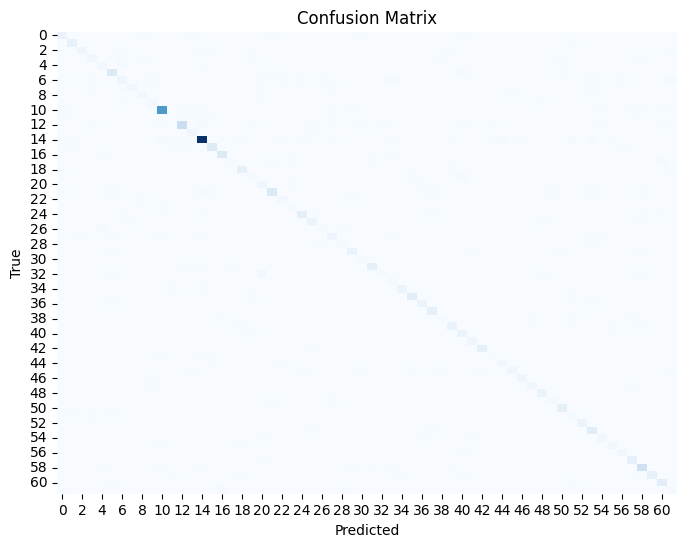

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap without numeric annotations
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, cmap='Blues', cbar=False)  
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Store the test set data in a folder, for model to predict

1. Loop through X_test (25% of data set) and reshape it back (data already been pre processed) and store it in a new folder

In [ ]:
# Set the path to the new folder for further testing
output_folder_path = 'further_testing'

# Create the output folder if it doesn't exist
os.makedirs(output_folder_path, exist_ok=True)

# Loop through each image in X_test along with its label from y_test
for i, (image_data, label) in enumerate(zip(X_test, y_test)):
    # Convert the image data to uint8 format
    image_data = (image_data * 255).astype(np.uint8)

    # Restore the image to its original shape
    original_shape = (64, 64)  # Assuming grayscale images
    original_image = image_data.reshape(original_shape)

    # Convert label to a valid filename format (replace any special characters)
    label_filename = label.replace(" ", "_")

    # Save the image to the new folder with the label in the filename
    output_image_path = os.path.join(output_folder_path, f'{label_filename}_image_{i}.jpg')
    cv2.imwrite(output_image_path, original_image)

print("Images saved to the new folder for further testing.")

2. Model will loop through the new folder and will predict all images

In [2]:
# Set the path to the folder for further testing
further_testing_path = 'further_testing'
best_svm = joblib.load('model.pkl')
pca = joblib.load('pca.joblib')

# Initialize counters for correct and incorrect predictions
correct_predictions = 0
incorrect_predictions = 0

# Loop through each image in the further_testing dataset
for image_filename in os.listdir(further_testing_path):
    image_path = os.path.join(further_testing_path, image_filename)

    # Load the preprocessed image data
    image_data = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Assuming images are grayscale
    image_data = image_data.astype('float32') / 255.0  # Normalize to [0, 1]

    # Reshape the image data to match the shape expected by the SVM model
    image_data_flattened = image_data.flatten()

    # Apply PCA transformation on the image data
    image_data_pca = pca.transform([image_data_flattened])

    # Use the trained SVM model to predict the label for the image data
    predicted_label = best_svm.predict(image_data_pca)

    # Extract the label from the image filename
    actual_label = image_filename.split("_")[0] + "_" + image_filename.split("_")[1]

    # Compare the predicted label with the actual label
    if predicted_label[0] == actual_label:
        correct_predictions += 1
    else:
        incorrect_predictions += 1

# Print the final results
print(f"Correct Predictions: {correct_predictions}")
print(f"Incorrect Predictions: {incorrect_predictions}")


Correct Predictions: 491
Incorrect Predictions: 265


### Deployment

In [17]:
joblib.dump(best_svm, 'model.pkl')

['model.pkl']

In [18]:
joblib.dump(pca, 'pca.joblib')

['pca.joblib']

Check app.py to test the model